In [17]:
import random
import numpy as np
import scipy.stats as stats
import time
phi = stats.norm.pdf

Phi = stats.norm.cdf
clone_bounds = lambda bounds: [list(bound) for bound in bounds]

class cube():
    
    #Can initialize point list
    
    def __init__(self,bounds,N = 0,mu = 0,mu_2 = 0,parent = False,cube_id = False, points = False,vals = False):
        
        self.cube_id = cube_id
        
        self.parent = parent
        
        self.bounds = bounds
        
        self.N = N
        
        self.mu = mu
        
        self.mu_2 = mu_2
        
        volume = 1
        
        for bound in bounds:
            
            volume *= bound[1] - bound[0]
            
        self.volume = volume
        
        if points:
            
            self.points = points
            
            self.vals = vals
            
        else:
        
            self.points = []
            
            self.vals = []
        
        return 
    
    #generating points should be the same
    
    def update_put(self):
               
        sig = self.var()**.5

        z = (self.parent.min_f-self.mu)/sig

        self.put = phi(z)*sig+Phi(z)*(self.parent.min_f-self.mu)
    
    def gen_point(self):
        
        dim = len(self.bounds)
        
        point = [0]*dim
        
        for k in range(dim):
            
            point[k] = np.random.uniform(*self.bounds[k])
            
        return point
        
        
    def var(self):
        
        return self.mu_2 - self.mu**2
    
    #needs to divy up points and vals now 
    
    def split(self,axis = -1, point = None):
        
        if axis == -1:
            
            n_ax = len(self.bounds)
            
            axis = random.randint(0,n_ax-1)
            
        a,b = self.bounds[axis]
            
        if point == None:
            #choose midpoint
            point = (a + b)/2
            
        parent_points = []
        child_points = []
        
        parent_vals = []
        child_vals = []
        
        #divide points
        
        for p,v in zip(self.points,self.vals):
            
            if p[axis] < point:
                child_points.append(p)
                child_vals.append(v)
            
            else:
                parent_points.append(p)
                parent_vals.append(v)

        N_child = len(child_points)
        
        N_parent = len(parent_points)
        
        child_bounds = clone_bounds(self.bounds)
        
        child_bounds[axis][1] = point #child gets top range cut off
        
        self.bounds[axis][0] = point #parent gets bottom range cut off
        
        parent = self.parent
        
        child = cube(child_bounds,N_child,self.mu,self.mu_2,parent)
        
        self.N = N_parent
        
        self.points = parent_points
        self.vals = parent_vals
        
        child.points = child_points
        child.vals = child_vals
        
        self.volume -= child.volume
        
        if self.parent:
            
            child.cube_id = len(self.parent.cubes) #put child at end of cube list
            
        child.update_put()
        
        self.update_put()
        
        return child
        
          

In [18]:
class policy():
    
    #init policy
    
    def __init__(self,bounds,f = lambda x: sum(x),v_0 = 1,mu_0 = 0):
        
        self.mean = mu_0
        
        self.var = v_0
        
        self.bounds = clone_bounds(bounds)
        
        self.cubes = []
        
        c0 = cube(clone_bounds(bounds),parent = self, cube_id = 0)
        
        self.cubes.append(c0)
        
        bounds = []

        for k in range(len(self.bounds)):

            bounds.append([[],[]])

            for Cube in self.cubes:

                bounds[k][0].append(Cube.bounds[k][0])
                bounds[k][1].append(Cube.bounds[k][1])
                
        self.cube_bounds = np.array(bounds)
        
        #initial empty min vals
        self.min_f = False
        self.min_p = False
        
        self.f = f
        
        return
    
    #updates cube bounds

    def update_cube_bounds(self,cube):

        n = cube.cube_id

        dim = 0

        for bound in cube.bounds:

            self.cube_bounds[dim][0][n] = bound[0]
            self.cube_bounds[dim][1][n] = bound[1]
            
            dim += 1
            
    #splits a cube         
        
    def split(self,n = 1.5,args = []):
        
        if n == 1.5:
            
            n = np.random.randint(0,len(self.cubes))
            
        child = self.cubes[n].split(*args) #splits cubes and updates bounds
        
        self.cubes.append(child) #adds child
        
        self.cube_bounds = self.cube_bounds.tolist()
        
        for k in range(len(self.bounds)): #updates cube bounds
            self.cube_bounds[k][0].append(0) #extends cube bounds
            
            self.cube_bounds[k][1].append(0)
            
        self.update_cube_bounds(child) #updates bounds for child
        self.update_cube_bounds(self.cubes[n]) #updates cube bounds for parent
        
        self.cube_bounds = np.array(self.cube_bounds) #re-cast bounds array

        return child
    
    #search algorithm
    #possibly can optimize given points are store
    #definitely can re-arrange ordering of conditions 

    def find(self,point):

        bounds = self.cube_bounds

        ids = np.array([k for k in range(len(self.cubes))])

        ax = 0

        l_u = 0

        while(len(ids)>1):

            temp = bounds[ax][l_u][ids]

            if l_u == 0:

                index = temp < point[ax]

                l_u += 1

            else:

                index = temp > point[ax]

                l_u = 0

                ax += 1

            ids = ids[index]

        return self.cubes[int(ids[0])]
    
    
    #finds min-variance boundary and devides cubes
    #Using points already seen
    #Need to check that min_n can even be satisfied
    
    def sample(self,cube,N_samples):
        
        points = [0]*N_samples
        vals = list(points)
        
        for k in range(N_samples):
            
            points[k] = cube.gen_point()
            vals[k] = self.f(points[k])
        
        #append points and vals to cube
        cube.points += points
        cube.vals += vals
        
        min_f = min(cube.vals)
        
        if not self.min_f or min_f < self.min_f: #update min if new one found
            
            self.min_f = min_f
            
            self.min_p = cube.points[cube.vals.index(min_f)]
        
        cube.N += len(points)
        
        cube.mu = sum(cube.vals)/cube.N
        
        cube.mu_2 = sum([y**2 for y in cube.vals])/cube.N
        
        N = 0
        
        for c in self.cubes:
            
            N += c.N

        if N == N_samples:
            
            self.var = 0
            
        self.var += self.mean**2
        
        self.mean *= (N - N_samples)
        
        self.mean += sum(vals)
        
        self.mean /= N
            
        self.var *= (N-N_samples)
        
        self.var += sum(y**2 for y in vals)
        
        self.var /= N
        
        self.var -= self.mean**2
        
        cube.update_put()
        
    #finds a good axis to split on

    def smart_split(self,cube,N_cuts,min_n = -1,sample_ratio = 10,lam = 1,verbose = 1):
        
        vol_tot = self.volume()
        
        if min_n and (cube.N < sample_ratio*min_n): #if cube doesn't have enough points you sample it
                
            N_sample = int(sample_ratio*min_n - cube.N) + 1

            self.sample(cube,N_sample)
        
        N_0 = cube.N #not sure we use this
        
        points = cube.points
        
        vals = cube.vals
        
        N_points = len(points)
                
        v_0 = cube.var()
        
        v_min = v_0 
        
        ax_min = -1
                
        bound_min = 0
        
        param_min = []
        
        #try n different divisions
        
        for k in range(N_cuts):
            
            #choose random axis
            
            ax = np.random.randint(0,len(self.bounds))
            
            #get bounds
            
            a,b = cube.bounds[ax]
            
            #test if min_n criteria is satisfied
            
            min_test = False
            
            while not min_test: #could be an infinite loop if unable to split
                
                #sort points
            
                boundary = a + np.random.uniform()*(b-a)

                points_par = []

                vals_par = []

                points_child = []

                vals_child = []

                #separate points

                for j in range(N_points):
                    
                    #right of boundary goes to parent

                    if points[j][ax] > boundary:

                        points_par.append(points[j])

                        vals_par.append(vals[j])
                        
                    #left to child

                    else:

                        points_child.append(points[j])

                        vals_child.append(vals[j])
                        
                #check min size
                        
                min_test = min(len(points_par),len(points_child)) > min_n

            #calc var

            var = 0
            
            width = b - a
            
            candidates = [[points_par,vals_par],[points_child,vals_child]]
                        
            params = []
            
            for j in range(2):
                
                #parent then child
                
                candidate = candidates[j]
                
                #number of after split
                
                N_cand = len(candidate[0])
                
                I = (j == 1)
                
                cand_prob = (I*(boundary - a) + (1-I)*(b-boundary))/width
                
                mu = sum(candidate[1]) / (N_cand)
                
                mu_2 = (sum([y**2 for y in candidate[1]])) / (N_cand)
                
                var_cand = mu_2 - mu**2
                
                params.append([mu,mu_2,N_cand])
                
                var += cand_prob*var_cand #conditional expected var
                
            if var < v_min:
                
                v_min = var
                
                ax_min = ax
                
                bound_min = boundary
                
                param_min = params 
                
        #if var is not reduced
        if ax_min == -1:
            
            if verbose:
            
                print("Failed to reduce var: ")

                print("Samples: ",N_points)

                print("Min N: ",min_n)

                print("Parent: ",cube.cube_id)
            
            return 
        
        if (v_0 - v_min)*cube.volume/vol_tot < lam:
            
            if verbose:
            
                print("Var Reduction Below Threshold")

                print("Var Reduction: ", v_0 - v_min)

                print("Lamda: ",lam)
                        
            return 

        #variance is reduced
            
        else:
            
            args = [ax_min,bound_min]
            
            #split cubes on boundary

            self.split(cube.cube_id,args) #CHECK IMPLEMENTATION
            
            par_child = [cube,self.cubes[-1]]
            
            for j in range(2):
                
                c = par_child[j]
                
                c.mu,c.mu_2,c.N = param_min[j]
                
            if verbose:

                print("Axis: ",ax_min)

                print("Boundary: ",bound_min)

                print("Var_0: ",v_0)

                print("Var_min",v_min)
            
        return points,vals
    
    #gets cube volume
    
    def volume(self):
        
        vol = 1
        
        for bound in self.bounds:
            
            vol *= bound[1] - bound[0]
            
        return vol
    
    #needs to be updated for thompson sampling
    
    def thomp_sample(self):
        
        #return np.random.randint(0,len(self.cubes))
        
        puts = self.puts()
        #puts = [1]*len(self.cubes)

        D = sum(puts)
        
        U = np.random.uniform()
        
        N = 0
        
        tot = puts[N]/D
        
        while U > tot:
            
            N += 1
            
            tot += puts[N]/D
        
        return N
    
    def puts(self,):
            
        return [c.put for c in self.cubes]
    
    
    def optimize(self,max_N,step_size,N_cuts = 10,min_n = -1,sample_ratio = 10,lam = 1,verbose = 1,skip = False):
    
            
        N = sum(cube.N for cube in self.cubes)
        
        if N == 0:
            
            self.sample(self.cubes[0],step_size)
        
        while N < max_N:
            
            if not skip:
                cube_id = self.thomp_sample()

            #cube_id = 0

            self.sample(self.cubes[cube_id],step_size)
            
            if not skip:
                self.smart_split(self.cubes[cube_id],N_cuts,min_n,sample_ratio,lam,verbose)
                
            N = sum(cube.N for cube in self.cubes)
            
        
            
        return  
            

In [19]:
#f = lambda X: 10*len(X)+sum([x**2 - 10*np.cos(.4*np.pi*x) for x in X])
#f = lambda X: -20*np.exp(-.2*(.5*sum(x**2 for x in X))**.5) - sum(np.exp(.5*(np.cos(np.pi*2*x))) for x in X) + np.e +20

f = lambda X: sum((X[k]*(k+1))*np.sin(abs(sum(X[j]*-1**(k+j)*j for j in range(len(X))))**.5*5) for k in range(len(X)))

#f = lambda X: sum(x**4 -6*x**2 + 5*np.sin(5*x) for x in X) + np.log(1+abs(sum(X)))

#f = lambda X: np.exp(abs(sum(x2 for x2 in X))**.51-np.log(1+abs(X[0])))

bounds = [[-10,10],[-10,10]]

res = 100

X = np.zeros([res-2,res-2])

dx = (bounds[0][1] - bounds[0][0])/res

Y = np.zeros([res-2,res-2])

dy = (bounds[1][1] - bounds[1][0])/res

Z = np.zeros([res-2,res-2])

for k in range(0,res-2):
    for j in range(0,res-2):
        
        X[k,j] = dx*(j+1) + bounds[0][0]
        Y[k,j] = dy*(k+1) + bounds[1][0]
        
        Z[k,j] = f([X[k,j],Y[k,j]])
        


    
Z0 = np.array(Z)

<IPython.core.display.Javascript object>


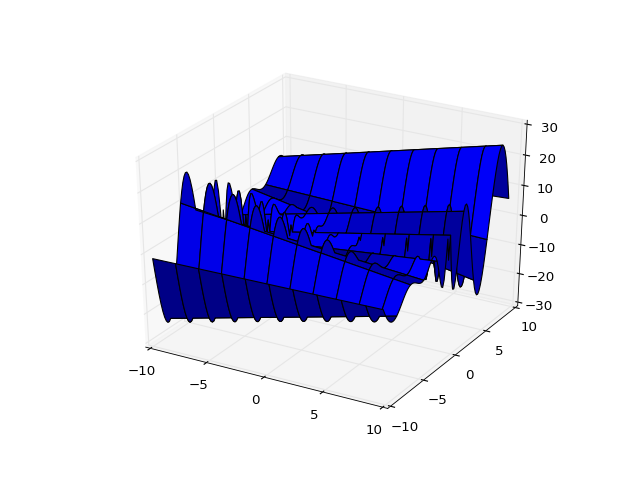

In [20]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z)

plt.show()

In [40]:
train_step = 50
max_n = train_step
step_size = 10
N_cuts = 10
Min_n = 1
sample_ratio = 4
lam = 0.01
Dim = 20
bounds = [[-100,100] for _ in range(Dim)]
pi = policy(bounds,f)

pi_2 = policy(bounds,f)


In [41]:
steps = 500
fr = 5

train_intervals = np.array([train_step*(k+1) for k in range(steps)])

train_1 = np.zeros([steps])
train_2 = np.zeros([steps])
skip = False

for k in range(steps):
    
    max_n = train_step*(k+1)
        
    pi.optimize(max_n,step_size,N_cuts,Min_n,sample_ratio,lam,verbose = 0,skip = skip)
    
    train_1[k] = pi.min_f

    samples = [pi.f(pi_2.cubes[0].gen_point()) for _ in range(step_size)]
    
    if k == 0:
        min_2 = min(samples)
    
    else:
        min_2 = min(min(samples),min_2)
        
    if k%fr == 0:
        print(k)
    
    train_2[k] = min_2

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495


<IPython.core.display.Javascript object>


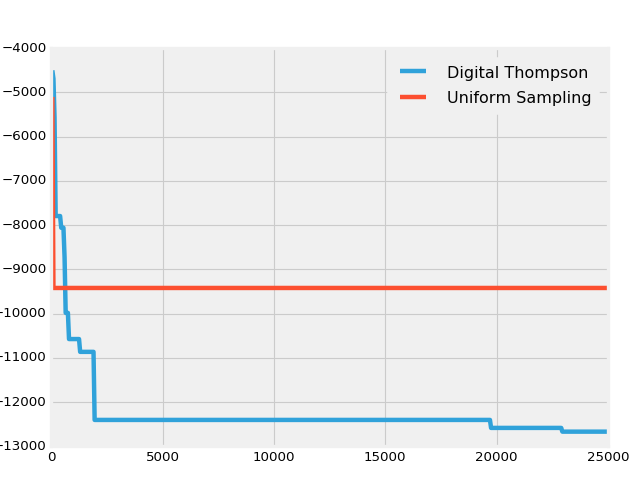

In [42]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt

with plt.style.context('fivethirtyeight'):
    plt.plot(train_intervals, train_1,label = "Digital Thompson")
    plt.plot(train_intervals, train_2,label = "Uniform Sampling")
    plt.legend()

plt.show()

<IPython.core.display.Javascript object>


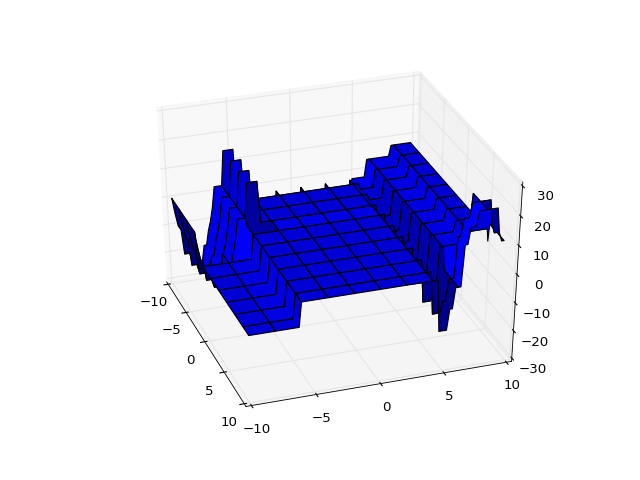

In [24]:
for k in range(0,res-2):
    for j in range(0,res-2):
        #print(dx*(j+1),dy*(k+1))
        Z[k,j] = pi.find([bounds[0][0]+dx*(j+1),bounds[1][0]+dy*(k+1)]).mu

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z)

plt.show()

In [25]:
pi.puts()

[9.6396944170743615e-12,
 1.8657448304087518e-08,
 7.5670945709733573e-07,
 4.0838262729832912e-39,
 7.5263749701753291e-09,
 6.7539514074817508e-55,
 4.3252927806066175e-23,
 2.0553876486733071e-28,
 8.1560565007020085e-09,
 5.6982708119566833e-07,
 8.1560565007020085e-09,
 9.1062843733241971e-08,
 5.6982708119566833e-07,
 6.1784835509583354e-15,
 9.1062843733241971e-08,
 4.1958634386935952e-13,
 4.1958634386935952e-13,
 3.9632504162674298e-07,
 6.75126832787613e-12,
 7.062850332393093e-09,
 0.0097315147952878669,
 1.5598067928093884e-86,
 1.8657448304087518e-08,
 1.3367534657948092e-05,
 6.1784835509583354e-15,
 7.5263749701753291e-09,
 9.801788585953526e-14,
 0.00093705222686125099,
 9.801788585953526e-14,
 6.7539514074817508e-55,
 2.2703033087313932e-09,
 1.4825020800547368e-05,
 7.4111812965308459e-164,
 2.7848365673579363e-29,
 4.0838262729832912e-39,
 5.2607978892429551e-05,
 5.2607978892429551e-05,
 9.6396944170743615e-12,
 2.7848365673579363e-29,
 2.2703033087313932e-09]

In [39]:
len(pi.cubes)

1031